In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from code.modelhelper import *

In [2]:
N_VOCAB = 5000
N_CLASS = 2
BATCH_SIZE = 256
EPOCHS = 300

In [5]:
x = np.load("data/xy/x_word_45_15.npy")
y = np.load("data/xy/y_onehot_45_15.npy")
x.shape, y.shape

((60000, 20), (60000, 2))

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=11)

# Word-level LSTM

In [7]:
model_input = Input(shape=(x.shape[1], ), name="m3_input")
H = Embedding(N_VOCAB, 32, name="m3_embedding")(model_input)
H = SpatialDropout1D(0.25, name="m3_spacialdropout1d")(H)
H = LSTM(32, name="m3_lstm")(H)
model_output = Dense(N_CLASS, activation="softmax", name="m3_output")(H)

model = Model(model_input, model_output)
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m3_input (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
m3_embedding (Embedding)     (None, 20, 32)            160000    
_________________________________________________________________
m3_spacialdropout1d (Spatial (None, 20, 32)            0         
_________________________________________________________________
m3_lstm (LSTM)               (None, 32)                8320      
_________________________________________________________________
m3_output (Dense)            (None, 2)                 66        
Total params: 168,386
Trainable params: 168,386
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(x_test, y_test),
    callbacks=[es]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/300
48000/48000 [==============================] - 5s 95us/sample - loss: 0.2964 - accuracy: 0.8756 - val_loss: 0.1168 - val_accuracy: 0.9629
Epoch 2/300
48000/48000 [==============================] - 3s 55us/sample - loss: 0.0980 - accuracy: 0.9676 - val_loss: 0.0916 - val_accuracy: 0.9710
Epoch 3/300
48000/48000 [==============================] - 3s 53us/sample - loss: 0.0747 - accuracy: 0.9768 - val_loss: 0.0852 - val_accuracy: 0.9732
Epoch 4/300
48000/48000 [==============================] - 3s 54us/sample - loss: 0.0645 - accuracy: 0.9800 - val_loss: 0.0877 - val_accuracy: 0.9702
Epoch 5/300
48000/48000 [==============================] - 2s 51us/sample - loss: 0.0591 - accuracy: 0.9813 - val_loss: 0.0894 - val_accuracy: 0.9729
Epoch 6/300
48000/48000 [==============================] - 3s 52us/sample - loss: 0.0559 - accuracy: 0.9827 - val_loss: 0.0859 - val_accuracy: 0.9724
Epoch 7/300
48000/48000 [=========================

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = to_bin(model.predict(x_test))
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.08519735573604703
Test accuracy: 0.97325
Test recall: 0.919905373436972
[[8957   84]
 [ 237 2722]]


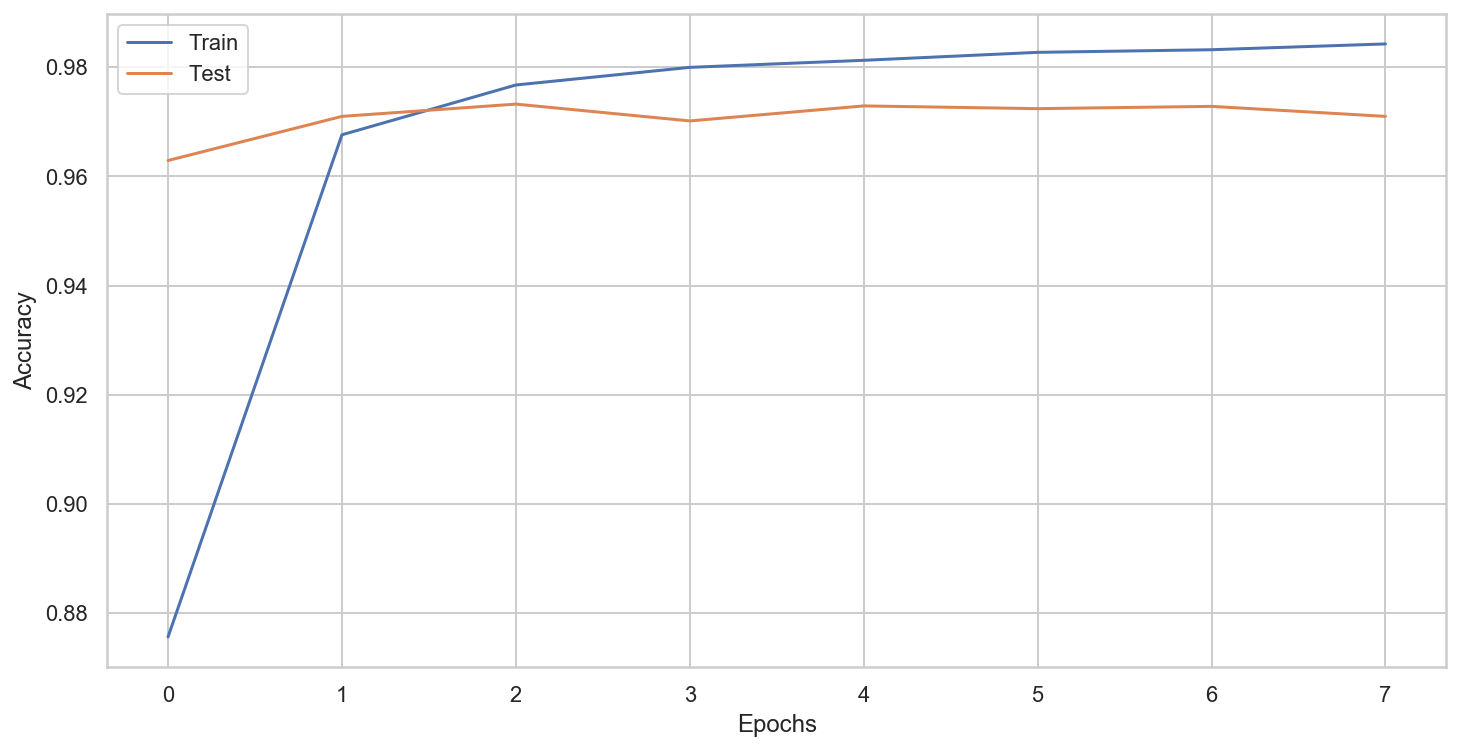

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [10]:
model.save("models/dl/m3_10000.h5")

# K-fold CV

In [8]:
model_params = {
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "es": es,
}

In [9]:
scores = kfold(model, model_params, x, y, 10)

Starting 10-fold cross validation:
    Validation 01 of 10 ... done [36.41s]
    Validation 02 of 10 ... done [16.59s]
    Validation 03 of 10 ... done [16.93s]
    Validation 04 of 10 ... done [17.21s]
    Validation 05 of 10 ... done [16.88s]
    Validation 06 of 10 ... done [16.76s]
    Validation 07 of 10 ... done [16.73s]
    Validation 08 of 10 ... done [16.51s]
    Validation 09 of 10 ... done [16.50s]
    Validation 10 of 10 ... done [16.50s]


In [10]:
arr = scores_dict_to_array(scores)
arr

array([[0.97016667, 0.9795    , 0.97933333, 0.97583333, 0.97866667,
        0.97933333, 0.983     , 0.98233333, 0.9845    , 0.98233333],
       [0.96344086, 0.98163842, 0.9844523 , 0.98571429, 0.98165138,
        0.98643826, 0.98053691, 0.98750867, 0.98612946, 0.99051787],
       [0.91304348, 0.93476799, 0.93177258, 0.91694352, 0.93168118,
        0.92938803, 0.95241199, 0.94176042, 0.95399361, 0.93590627],
       [0.01126325, 0.00576113, 0.00488346, 0.00444939, 0.0057688 ,
        0.00421006, 0.00649351, 0.0040098 , 0.00473506, 0.00285777]])

In [11]:
np.save("cv/m3_cv.npy", arr)